In [ ]:
import torch
from torch import nn
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class Encoder(nn.Module):
    def __init__(self,channels) -> None:
        super().__init__()
        def conv(inc,outc,act):
            return nn.Sequential(
                nn.Conv2d(inc,outc,3,bias=False,stride=2,padding=1),
                nn.BatchNorm2d(outc),
                act(),
            )
        layers = []
        for i, (inc, outc) in enumerate(zip(channels[:-1], channels[1:])):
            act = nn.ReLU if i == len(channels)-2 else nn.Identity
            layers.extend([
                conv(inc, outc,act),
            ])
        self.layers = nn.ModuleList(layers)
    def forward(self,x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
class BottleNeck(nn.Module):
    def __init__(self, inc,outc) -> None:
        super().__init__()
        self.mean = nn.Conv2d(inc,outc,3,padding="same")
        self.var = nn.Conv2d(inc, outc, 3, padding="same")
    def forward(self,x):
        mean, var = self.mean(x), torch.exp(self.mean(x))
        distribution = torch.distributions.Normal(mean, torch.sqrt(torch.exp(var)))
        samples = distribution.rsample()
        return samples,mean,var
class Decoder(nn.Module):
    def __init__(self, channels) -> None:
        super().__init__()
        def conv(inc,outc,act):
            return nn.Sequential(
                nn.ConvTranspose2d(inc, outc, 3, bias=False,stride=2,padding=1, output_padding=1),
                nn.BatchNorm2d(outc),
                act(),
            )
        layers = []
        for i, (inc, outc) in enumerate(zip(channels[:-1], channels[1:])):
            act = nn.ReLU if i == len(channels)-2 else nn.Identity
            layers.extend([
                conv(inc, outc, act),
            ])
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
class Autoencoder(nn.Module):
    def __init__(self, inc) -> None:
        super().__init__()
        latentc = 64
        encoderc = [inc,32,latentc] 
        decoderc = encoderc[::-1]
        self.encoder = Encoder(encoderc)
        self.bottleneck = BottleNeck(latentc, latentc)
        self.decoder = Decoder(decoderc)
    def forward(self,x):
        shape = x.shape
        x = self.encoder(x)
        # print(x.shape)
        x,mean,var = self.bottleneck(x)
        # print(x.shape)
        x = self.decoder(x)
        assert x.shape == shape,(x.shape,shape)
        return F.sigmoid(x),mean,var


model = Autoencoder(1).to(device)
optimizer = torch.optim.Adam(model.parameters())
losses = []
# Autoencoder(1).forward(torch.empty((3, 1, 28, 28)))[0].shape

In [ ]:
import torch.utils.data
import torchvision
batch_size = 64*2
train_dl = torch.utils.data.DataLoader(
    torchvision.datasets.FashionMNIST(
        "/datasets/fashion",
        download=True,
        transform=torchvision.transforms.ToTensor()
    ),
    shuffle=True,batch_size=batch_size,
)
len(train_dl)

EPOCH 10 : loss= 0.1423: 100%|██████████| 10/10 [02:06<00:00, 12.67s/it]


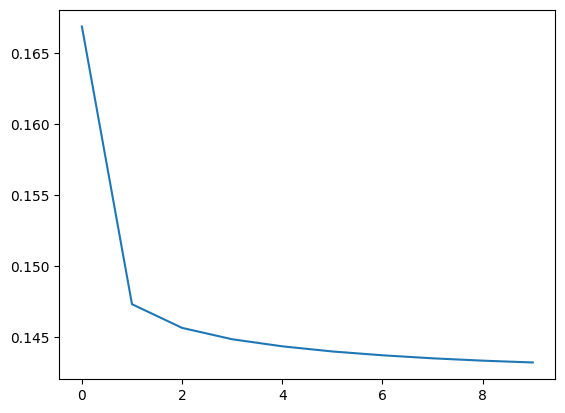

In [4]:
import tqdm

def train(model, epochs=10, losses=[]):
    model.train()
    try:
        for epoch in (bar := tqdm.trange(epochs)):
            epoch_losses = []
            for x,_ in train_dl:
                x = x.float().to(device)
                logits,mean,log_var = model(x)
                dkl = (1+log_var - torch.exp(mean)**2 - torch.exp(log_var)) / 2
                loss = F.mse_loss(logits, x) - dkl.mean()

                # Optimizer step
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                epoch_losses.append(loss.item())
                bar.set_description(f"EPOCH {epoch + 1:2} : loss= {np.mean(epoch_losses[-10:]):.4f}")
            losses.append(np.mean(epoch_losses))
    except KeyboardInterrupt as e:
        print("Training stopped")
        pass
    return losses


losses = train(model, 10, losses=losses)
plt.plot(losses)

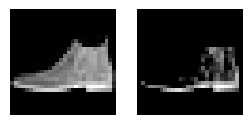

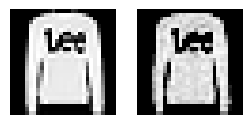

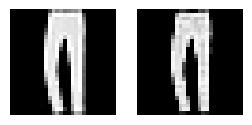

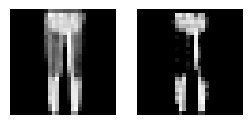

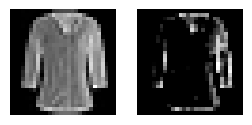

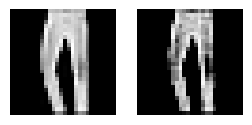

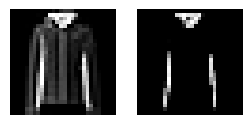

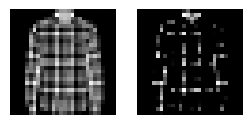

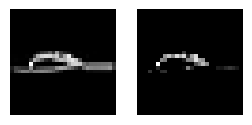

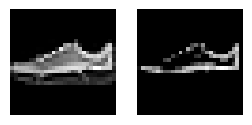

In [5]:
def imshow(img,ax=None,cmap="gray"):
    if ax is None:
        ax = plt
    ax.imshow(img,cmap=cmap)
    ax.axis("off")


test_dl = torch.utils.data.DataLoader(
    torchvision.datasets.FashionMNIST(
        "/datasets/fashion",
        download=True,
        train=False,
        transform=torchvision.transforms.ToTensor()
    ),
    shuffle=False, batch_size=10,
)
with torch.no_grad():
    model.eval()
    images,y = next(iter(test_dl))
    results = model.forward(images.to(device))[0]
for image,result_image in zip(images.numpy(),results.cpu().numpy()):
    _,(ax1,ax2) = plt.subplots(1,2,figsize=(3,3))
    imshow(image[0],ax1)
    imshow(result_image[0], ax2)